# Functions: Schaffer N.2 and Ackley

This notebook defines and visualizes two  optimization functions for use in genetic algorithm experiments.

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Function Definitions

In [2]:

def schaffer_n2(x, y):
    numerator = np.sin(x**2 - y**2)**2 - 0.5
    denominator = (1 + 0.001 * (x**2 + y**2))**2
    return 0.5 + numerator / denominator

def ackley(x, y, a=20, b=0.2, c=2*np.pi):
    part1 = -a * np.exp(-b * np.sqrt(0.5 * (x**2 + y**2)))
    part2 = -np.exp(0.5 * (np.cos(c*x) + np.cos(c*y)))
    return part1 + part2 + 20 + np.e

## Generate Grids

In [3]:
# Create grids
x_sch, y_sch = np.meshgrid(np.linspace(-100, 100, 400), np.linspace(-100, 100, 400))
z_sch = schaffer_n2(x_sch, y_sch)

x_ack, y_ack = np.meshgrid(np.linspace(-5, 5, 400), np.linspace(-5, 5, 400))
z_ack = ackley(x_ack, y_ack)

## Plotting Functions

In [4]:
def plot_contour_3d(x, y, z, title):
    fig = plt.figure(figsize=(16, 6))
    ax1 = fig.add_subplot(1, 2, 1)
    cp = ax1.contourf(x, y, z, levels=50, cmap='viridis')
    fig.colorbar(cp, ax=ax1)
    ax1.set_title(f"{title} - Contour Plot")
    ax1.set_xlabel("x")
    ax1.set_ylabel("y")

    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    surf = ax2.plot_surface(x, y, z, cmap='viridis', edgecolor='none')
    fig.colorbar(surf, ax=ax2)
    ax2.set_title(f"{title} - 3D Surface Plot")
    ax2.set_xlabel("x")
    ax2.set_ylabel("y")
    ax2.set_zlabel("f(x, y)")

    plt.tight_layout()
    plt.show()

## Plot: Schaffer Function N.2

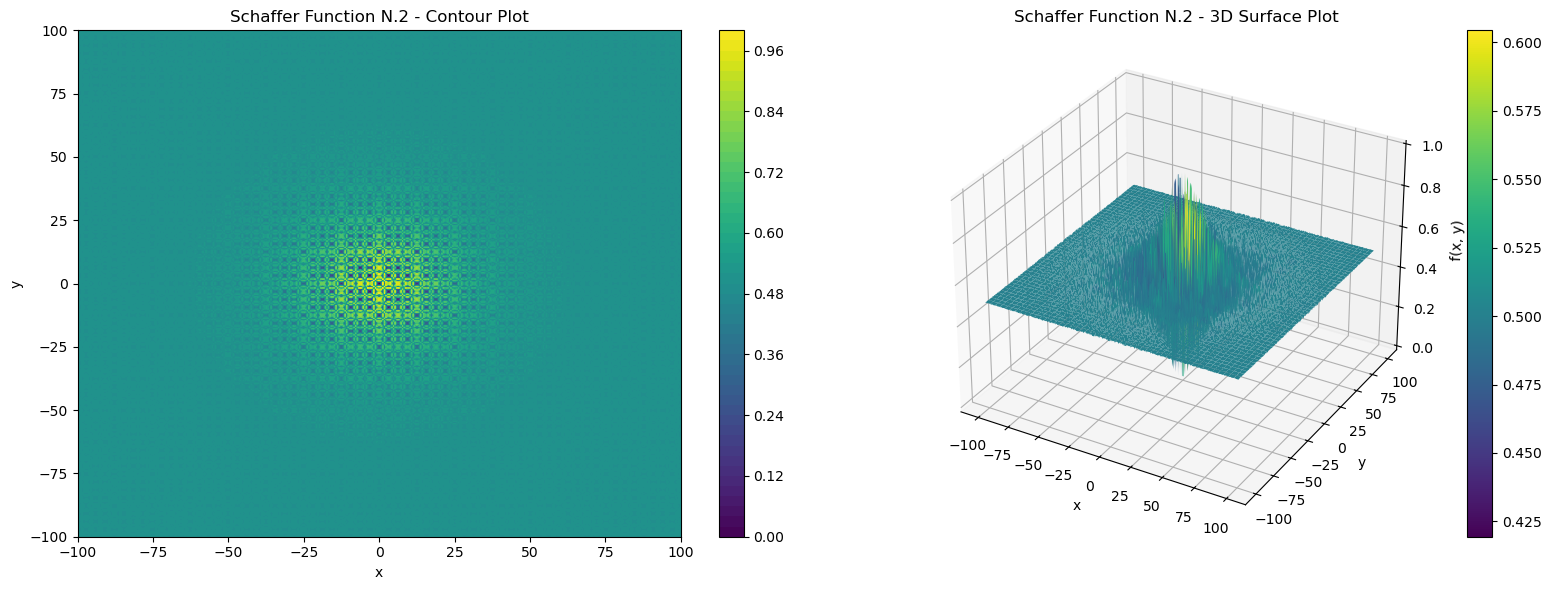

In [5]:
plot_contour_3d(x_sch, y_sch, z_sch, "Schaffer Function N.2")

## Plot: Ackley Function

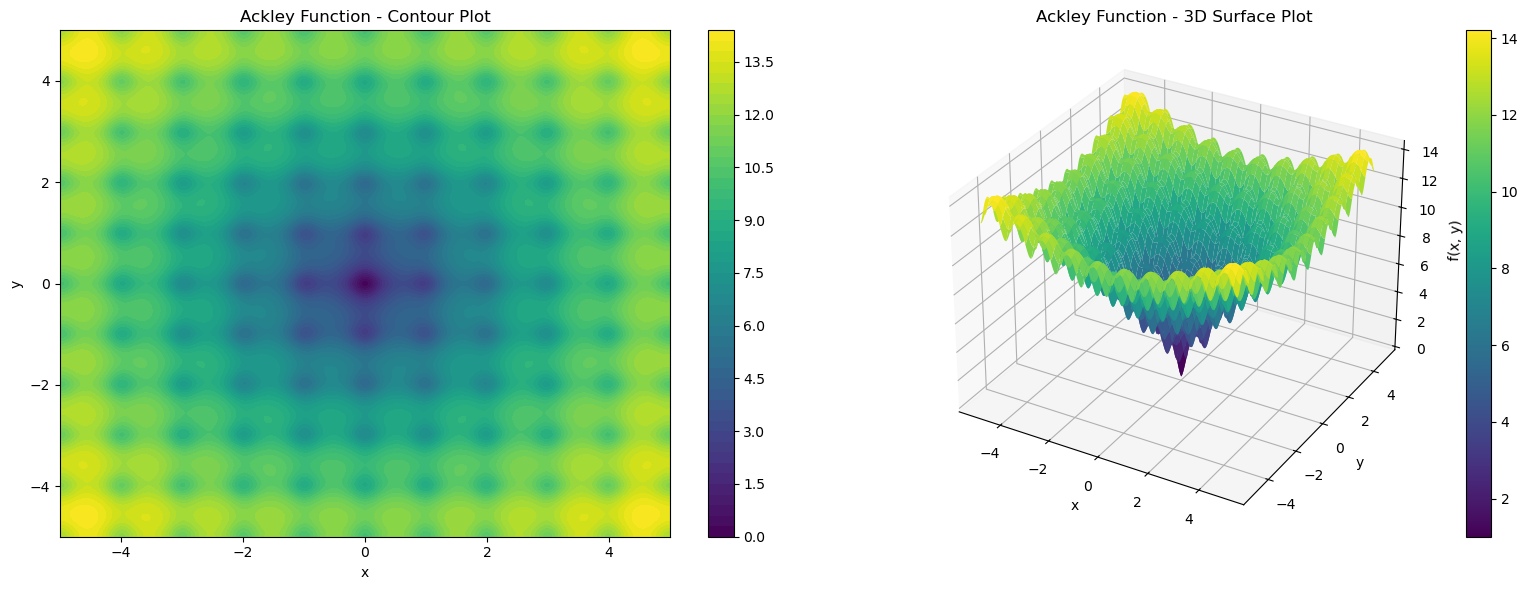

In [6]:
plot_contour_3d(x_ack, y_ack, z_ack, "Ackley Function")

## Genetic Algorithm Class with Both Encodings

In [7]:
class GeneticAlgorithm:
    def __init__(self, func, domain, encoding='real', crossover='arithmetic',
                 pop_size=50, mutation_rate=0.01, crossover_rate=0.9,
                 generations=100, bit_length=16):
        self.func = func
        self.domain = domain
        self.encoding = encoding
        self.crossover = crossover
        self.pop_size = pop_size
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.generations = generations
        self.bit_length = bit_length
        self.population = self.initialize_population()

    def float_to_bin(self, val):
        min_val, max_val = self.domain
        norm = (val - min_val) / (max_val - min_val)
        return format(int(norm * (2**self.bit_length - 1)), f'0{self.bit_length}b')

    def bin_to_float(self, bin_str):
        min_val, max_val = self.domain
        intval = int(bin_str, 2)
        norm = intval / (2**self.bit_length - 1)
        return min_val + norm * (max_val - min_val)

    def encode(self, vector):
        return ''.join([self.float_to_bin(v) for v in vector])

    def decode(self, chromosome):
        return [self.bin_to_float(chromosome[i:i+self.bit_length])
                for i in range(0, len(chromosome), self.bit_length)]

    def initialize_population(self):
        if self.encoding == 'real':
            return [np.random.uniform(self.domain[0], self.domain[1], size=2) for _ in range(self.pop_size)]
        else:
            return [self.encode(np.random.uniform(self.domain[0], self.domain[1], size=2))
                    for _ in range(self.pop_size)]

    def evaluate_population(self):
        if self.encoding == 'real':
            return [self.func(ind[0], ind[1]) for ind in self.population]
        else:
            return [self.func(*self.decode(ind)) for ind in self.population]

    def select_parents(self, fitness):
        idx = np.argsort(fitness)
        return [self.population[i] for i in idx[:2]]

    def crossover_operator(self, parent1, parent2):
        if self.encoding == 'real':
            if self.crossover == 'arithmetic':
                alpha = np.random.rand()
                return alpha * parent1 + (1 - alpha) * parent2, alpha * parent2 + (1 - alpha) * parent1
            elif self.crossover == 'blx':
                alpha = 0.5
                min_vals = np.minimum(parent1, parent2)
                max_vals = np.maximum(parent1, parent2)
                diff = max_vals - min_vals
                low = min_vals - alpha * diff
                high = max_vals + alpha * diff
                return np.random.uniform(low, high), np.random.uniform(low, high)
        else:
            point = random.randint(1, len(parent1) - 1) if self.crossover == '1point' else sorted(
                random.sample(range(1, len(parent1)), 2))
            if isinstance(point, list):
                p1 = parent1[:point[0]] + parent2[point[0]:point[1]] + parent1[point[1]:]
                p2 = parent2[:point[0]] + parent1[point[0]:point[1]] + parent2[point[1]:]
            else:
                p1 = parent1[:point] + parent2[point:]
                p2 = parent2[:point] + parent1[point:]
            return p1, p2

    def mutate(self, individual):
        if self.encoding == 'real':
            for i in range(len(individual)):
                if random.random() < self.mutation_rate:
                    individual[i] += np.random.normal(0, 0.1)
                    individual[i] = np.clip(individual[i], self.domain[0], self.domain[1])
            return individual
        else:
            individual = list(individual)
            for i in range(len(individual)):
                if random.random() < self.mutation_rate:
                    individual[i] = '1' if individual[i] == '0' else '0'
            return ''.join(individual)

    def run(self):
        best_solution = None
        best_fitness = float('inf')
        for _ in range(self.generations):
            fitness = self.evaluate_population()
            new_population = []
            for _ in range(self.pop_size // 2):
                p1, p2 = self.select_parents(fitness)
                if random.random() < self.crossover_rate:
                    c1, c2 = self.crossover_operator(p1, p2)
                else:
                    c1, c2 = p1, p2
                new_population.extend([self.mutate(c1), self.mutate(c2)])
            self.population = new_population
            best_gen = min(fitness)
            if best_gen < best_fitness:
                best_fitness = best_gen
                best_solution = self.population[np.argmin(fitness)]
        if self.encoding == 'binary':
            best_solution = self.decode(best_solution)
        return best_solution, best_fitness

## Example Run:

In [8]:
ga_bin_ack = GeneticAlgorithm(
    func=ackley,
    domain=[-5, 5],
    encoding='binary',
    crossover='2point',
    pop_size=50,
    mutation_rate=0.01,
    crossover_rate=0.9,
    generations=100
)
best_sol_bin_ack, best_fit_bin_ack = ga_bin_ack.run()
print("Best solution (Binary Ackley):", best_sol_bin_ack)
print("Best fitness (Binary Ackley):", best_fit_bin_ack)

Best solution (Binary Ackley): [7.629510948348184e-05, -0.0002288853284504455]
Best fitness (Binary Ackley): 0.0003054904423653859


In [9]:
ga = GeneticAlgorithm(
    func=schaffer_n2,
    domain=[-100, 100],
    encoding='binary',
    crossover='1point',
    pop_size=50,
    mutation_rate=0.01,
    crossover_rate=0.9,
    generations=100
)

best_solution, best_fitness = ga.run()
print("Best solution (binary):", best_solution)
print("Best fitness (Schaffer):", best_fitness)

Best solution (binary): [-0.0015259021896696368, -0.0015259021896696368]
Best fitness (Schaffer): 4.656754926113393e-09


In [10]:
ga_ack = GeneticAlgorithm(
    func=ackley,
    domain=[-5, 5],
    encoding='real',
    crossover='arithmetic',
    pop_size=50,
    mutation_rate=0.05,
    crossover_rate=0.9,
    generations=100
)
best_sol_ack, best_fit_ack = ga_ack.run()
print("Best solution (Ackley):", best_sol_ack)
print("Best fitness (Ackley):", best_fit_ack)

Best solution (Ackley): [0.05930513 0.21891515]
Best fitness (Ackley): 1.7811818996182893e-05


## Optimization Experiments + Statistical Analysis

In [11]:
import pandas as pd
import numpy as np

functions = {
    "ackley": (ackley, [-5, 5]),
    "schaffer": (schaffer_n2, [-100, 100])
}
encodings = ["real", "binary"]
crossover_methods = {
    "real": ["arithmetic", "blx"],
    "binary": ["1point", "2point"]
}

results = []

for fname, (func, domain) in functions.items():
    for enc in encodings:
        for cross in crossover_methods[enc]:
            for run in range(30):  # 30 independent runs
                ga = GeneticAlgorithm(
                    func=func,
                    domain=domain,
                    encoding=enc,
                    crossover=cross,
                    pop_size=50,
                    mutation_rate=0.01 if enc == "binary" else 0.05,
                    crossover_rate=0.9,
                    generations=100
                )
                best_sol, best_fit = ga.run()
                results.append({
                    "function": fname,
                    "encoding": enc,
                    "crossover": cross,
                    "run": run,
                    "fitness": best_fit
                })

# Save or convert results
df = pd.DataFrame(results)
df.to_csv("ga_results.csv", index=False)
df.groupby(["function", "encoding", "crossover"])["fitness"].describe()


count      mean       std           min  \
function encoding crossover                                             
ackley   binary   1point       30.0  0.000305  0.000000  3.054904e-04   
                  2point       30.0  0.119501  0.652862  3.054904e-04   
         real     arithmetic   30.0  1.740838  1.548787  4.804349e-09   
                  blx          30.0  0.678865  1.312598  1.348989e-08   
schaffer binary   1point       30.0  0.029690  0.042266  4.656755e-09   
                  2point       30.0  0.029642  0.036577  1.214163e-04   
         real     arithmetic   30.0  0.144996  0.120411  3.126607e-03   
                  blx          30.0  0.087651  0.104486  1.034423e-09   

                                   25%       50%       75%       max  
function encoding crossover                                           
ackley   binary   1point      0.000305  0.000305  0.000305  0.000305  
                  2point      0.000305  0.000305  0.000305  3.576177  
         real     arithmetic  0.000028  2.579928  2.579928  5.381864  
                  blx         0.000005  0.000037  0.000706  4.884065  
schaffer binary   1point      0.002467  0.010410  0.040606  0.139928  
                  2point      0.002411  0.015526  0.042593  0.140845  
         real     arithmetic  0.037788  0.114536  0.249816  0.376106  
                  blx         0.008251  0.040288  0.144338  0.431329

## Summary statistics:

In [12]:
summary = df.groupby(["function", "encoding", "crossover"])["fitness"].agg(["mean", "std", "min", "max"])
print(summary)


                                  mean       std           min       max
function encoding crossover                                             
ackley   binary   1point      0.000305  0.000000  3.054904e-04  0.000305
                  2point      0.119501  0.652862  3.054904e-04  3.576177
         real     arithmetic  1.740838  1.548787  4.804349e-09  5.381864
                  blx         0.678865  1.312598  1.348989e-08  4.884065
schaffer binary   1point      0.029690  0.042266  4.656755e-09  0.139928
                  2point      0.029642  0.036577  1.214163e-04  0.140845
         real     arithmetic  0.144996  0.120411  3.126607e-03  0.376106
                  blx         0.087651  0.104486  1.034423e-09  0.431329


## T-test

In [13]:
from scipy.stats import ttest_ind

# t-test between real and binary encoding for Ackley
group1 = df[(df["function"] == "ackley") & (df["encoding"] == "real")]["fitness"]
group2 = df[(df["function"] == "ackley") & (df["encoding"] == "binary")]["fitness"]
t_stat, p_value = ttest_ind(group1, group2)
print("T-test result for Ackley (real vs binary):", t_stat, p_value)


T-test result for Ackley (real vs binary): 5.604795197588125 1.3900561227453396e-07


## Boxplot:

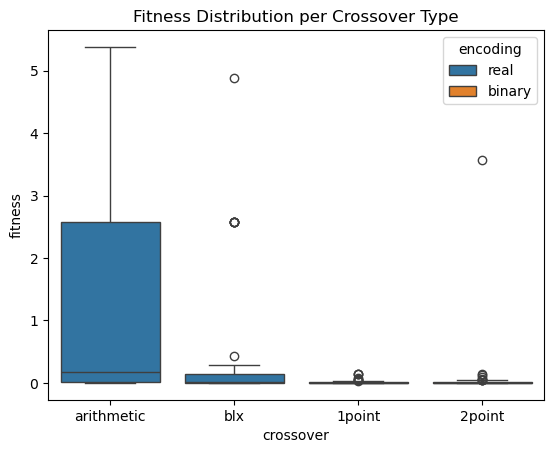

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(data=df, x="crossover", y="fitness", hue="encoding")
plt.title("Fitness Distribution per Crossover Type")
plt.show()


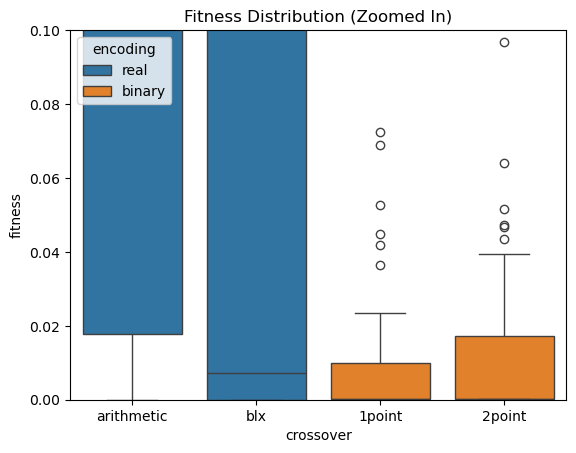

In [15]:
sns.boxplot(data=df, x="crossover", y="fitness", hue="encoding")
plt.ylim(0, 0.1)  # zoom into the lower fitness values
plt.title("Fitness Distribution (Zoomed In)")
plt.show()

1. Binary encoding outperforms real encoding

Binary with 1point crossover has very low and consistent fitness.

Real encoding has higher spread and worse medians.

2. Among binary crossovers, 1point is better than 2point

2point has more variation and slightly worse performance on average.

3. Real encoding with blx is slightly better than with arithmetic, but still worse than binary.

## Binary-1point vs Real-arithmetic

/var/folders/39/jtc65_f90s58dks4t3gg9j6r0000gn/T/ipykernel_69912/3961733484.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=comparison_df, x="group", y="fitness", palette="Set2")


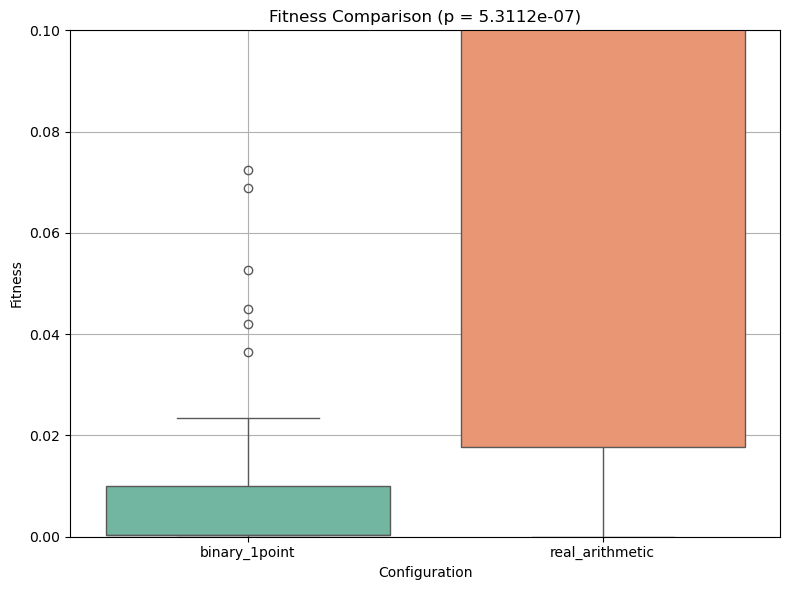

T-statistic: -5.3064
P-value: 5.3112e-07


In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

binary_1point = df[(df["crossover"] == "1point") & (df["encoding"] == "binary")]["fitness"]
real_arithmetic = df[(df["crossover"] == "arithmetic") & (df["encoding"] == "real")]["fitness"]

t_stat, p_val = ttest_ind(binary_1point, real_arithmetic)


comparison_df = pd.DataFrame({
    "fitness": list(binary_1point) + list(real_arithmetic),
    "group": ["binary_1point"] * len(binary_1point) + ["real_arithmetic"] * len(real_arithmetic)
})


plt.figure(figsize=(8, 6))
sns.boxplot(data=comparison_df, x="group", y="fitness", palette="Set2")
plt.ylim(0, 0.1)  #focus on small fitness values
plt.title(f"Fitness Comparison (p = {p_val:.4e})")
plt.xlabel("Configuration")
plt.ylabel("Fitness")
plt.grid(True)
plt.tight_layout()
plt.show()


print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_val:.4e}")

Conclusion: Binary encoding with 1-point crossover performs **significantly better** than real-valued encoding with arithmetic crossover(bacause p-value < 0.05)

## Schaffer function, where only population size changes

In [17]:
pop_sizes = [30, 50, 75, 100, 150]
results = []

for pop in pop_sizes:
    for run in range(10):  # 10 runs per population size
        ga = GeneticAlgorithm(
            func=schaffer_n2,
            domain=[-100, 100],
            encoding='binary',  # or 'real'
            crossover='1point',  # keep this fixed
            pop_size=pop,
            mutation_rate=0.01,
            crossover_rate=0.9,
            generations=100
        )
        best_sol, best_fit = ga.run()
        results.append({
            "function": "schaffer",
            "population": pop,
            "fitness": best_fit,
            "run": run
        })

# Save to DataFrame
df_schaffer_pop = pd.DataFrame(results)
df_schaffer_pop.to_csv("schaffer_population_experiment.csv", index=False)


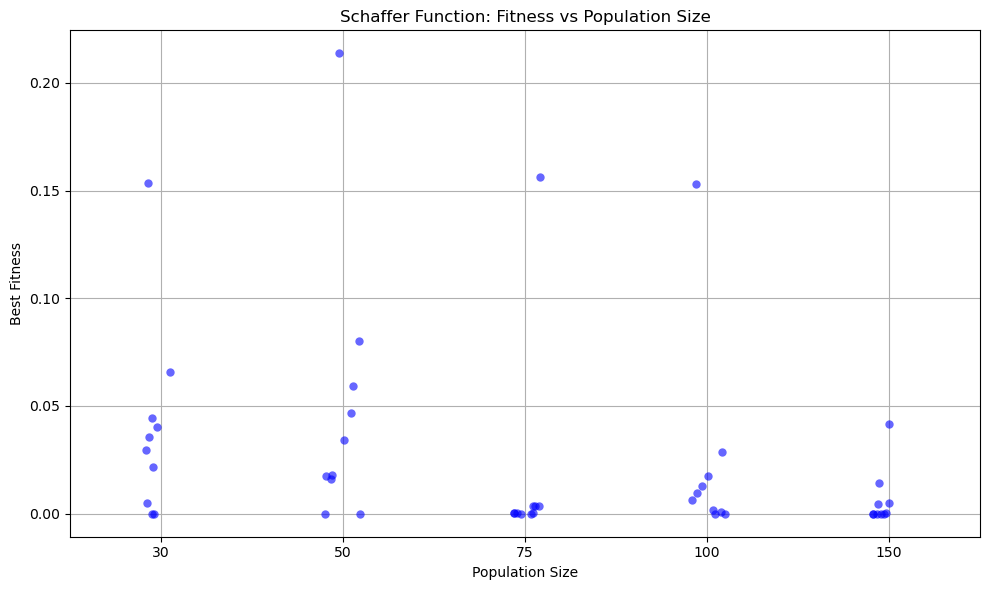

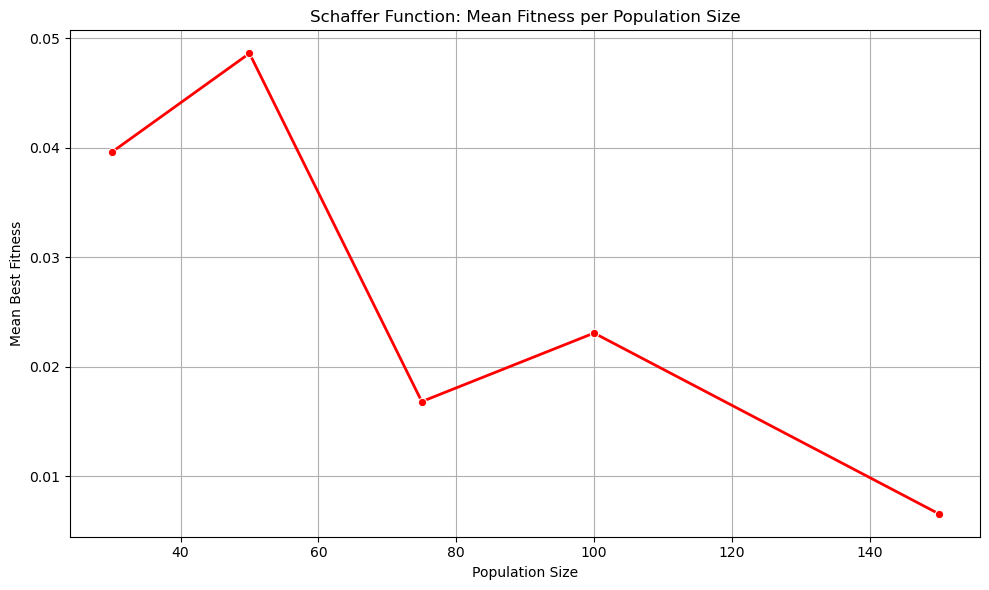

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("schaffer_population_experiment.csv")

# Filter only if needed
df = df[df["function"] == "schaffer"]

# Plot: stripplot with dots
plt.figure(figsize=(10, 6))
sns.stripplot(data=df, x="population", y="fitness", jitter=True, size=6, color="blue", alpha=0.6)
plt.title("Schaffer Function: Fitness vs Population Size")
plt.xlabel("Population Size")
plt.ylabel("Best Fitness")
plt.grid(True)
plt.tight_layout()
plt.show()

# Compute mean fitness per population size
mean_df = df.groupby("population", as_index=False)["fitness"].mean()

# Plot: mean fitness as red line
plt.figure(figsize=(10, 6))
sns.lineplot(data=mean_df, x="population", y="fitness", color="red", marker="o", linewidth=2)
plt.title("Schaffer Function: Mean Fitness per Population Size")
plt.xlabel("Population Size")
plt.ylabel("Mean Best Fitness")
plt.grid(True)
plt.tight_layout()
plt.show()


## Fitness vs Population Size
You can clearly see a higher variance and worse results when the population is small (e.g. 30–50).

As population size increases:

-Results become more consistent.

-Best fitness values cluster closer to zero, which is ideal.


## Ackley function, real encoding, and arithmetic crossover

In [19]:
pop_sizes = [30, 50, 75, 100, 150]
results = []

for pop in pop_sizes:
    for run in range(10):  # 10 runs per population size
        ga = GeneticAlgorithm(
            func=ackley,
            domain=[-100, 100],
            encoding='real',  
            crossover='arithmetic', 
            pop_size=pop,
            mutation_rate=0.01,
            crossover_rate=0.9,
            generations=100
        )
        best_sol, best_fit = ga.run()
        results.append({
            "function": "ackley",
            "population": pop,
            "fitness": best_fit,
            "run": run
        })

# Save to DataFrame
df_ackley_pop = pd.DataFrame(results)
df_ackley_pop.to_csv("ackley_population_experiment.csv", index=False)

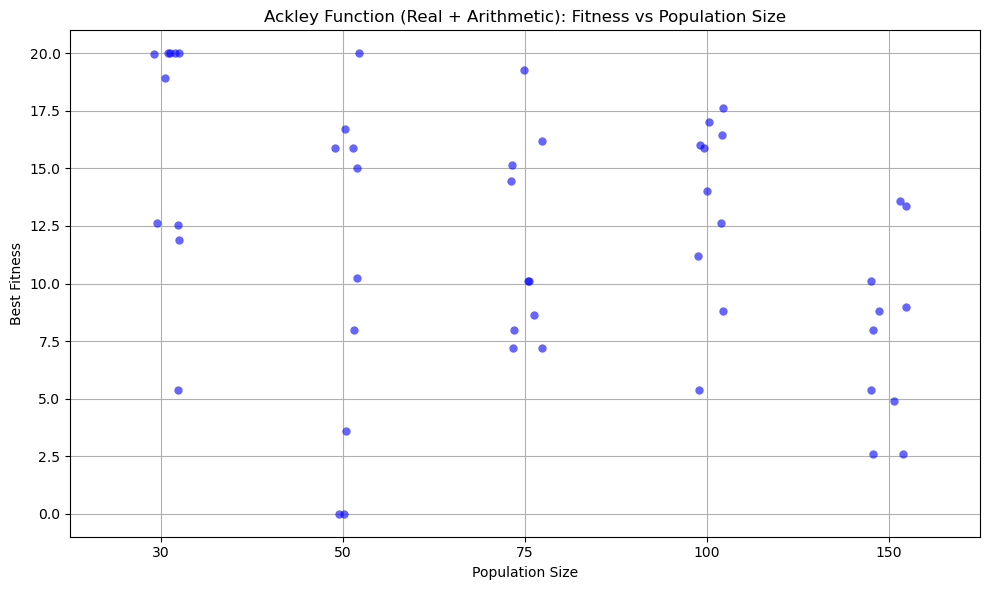

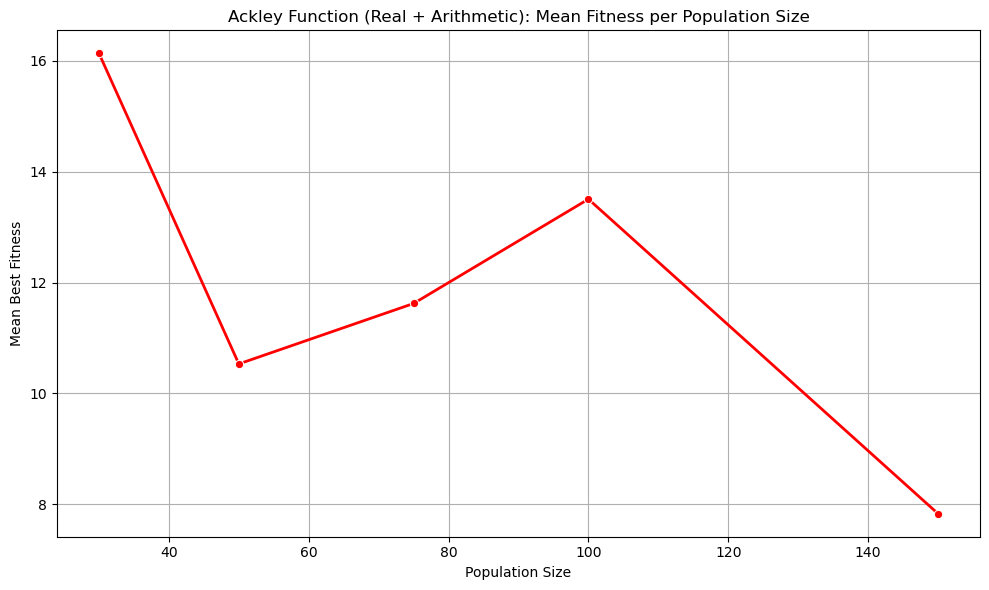

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your experimental results CSV
df = pd.read_csv("ackley_population_experiment.csv")  

# Filter for Ackley function using real + arithmetic
df_ackley = df[(df["function"] == "ackley")]

# -------- Plot 1: individual fitness points --------
plt.figure(figsize=(10, 6))
sns.stripplot(data=df_ackley, x="population", y="fitness", jitter=True, size=6, color="blue", alpha=0.6)
plt.title("Ackley Function (Real + Arithmetic): Fitness vs Population Size")
plt.xlabel("Population Size")
plt.ylabel("Best Fitness")
plt.grid(True)
plt.tight_layout()
plt.show()

# -------- Plot 2: mean fitness per population --------
mean_ackley = df_ackley.groupby("population", as_index=False)["fitness"].mean()

plt.figure(figsize=(10, 6))
sns.lineplot(data=mean_ackley, x="population", y="fitness", color="red", marker="o", linewidth=2)
plt.title("Ackley Function (Real + Arithmetic): Mean Fitness per Population Size")
plt.xlabel("Population Size")
plt.ylabel("Mean Best Fitness")
plt.grid(True)
plt.tight_layout()
plt.show()


A clear trend: at smaller population sizes (30–50), results are highly scattered and often far from optimal (values near 20 are quite poor).

As the population size increases to 100 and 150, fitness values become:

    Lower (closer to optimal)

    More consistent (less variation across runs)

Fitness initially increases slightly from 30 to 50 (a possible artifact of randomness).

Then it steadily improves as population grows from 50 to 150.

The lowest average fitness is achieved at population 150, indicating best overall performance.

